In [50]:
import pandas
import datetime
import numpy as np
from matplotlib.pyplot import (figure, plot, title, xlabel, ylabel, 
                               colorbar, imshow, xticks, yticks, show, style, scatter, subplots)
import geopy.distance
import utm
import simplekml

style.use('seaborn-darkgrid')

# Data Set

For this task the two dataset that we are using are the `SONAR_DATASET` and the `GPS_RTK_DATASET`

In [3]:
SONAR_DATASET = "./csv/GA_near_boat.csv"
GPS_RTK_DATASET = "./csv/guden_a_WITH_time_stamp.csv"

# Processing The Sonar Data
## Loading the data
The first step is to import the bathymetry data, which is stored with a comma-separated standard in the notebook using _pandas_.
The name chosen for the _pandas_ data frame is `sonar_raw_df`. This data frame will only contain the raw data captured by the sonar.


In [4]:
sonar_raw_df = pandas.read_csv(SONAR_DATASET)

When the data is load a meaningfull name to each column is assigned.

In [5]:
sonar_raw_df.columns = ["lat", "long", "deep", "timestamp"]
print(sonar_raw_df.head())

   lat  long   deep      timestamp
0  0.0   0.0  3.887  1581608392148
1  0.0   0.0  3.887  1581608392628
2  0.0   0.0  3.887  1581608392630
3  0.0   0.0  3.887  1581608392789
4  0.0   0.0  3.887  1581608392790


## Converting the timestamp

In order to facilitate the analysis of the data, the timestamp format is converted from Unix timestamp to date and time.

In [6]:
sonar_raw_df['datetime'] = (list(map(lambda x: datetime.datetime.fromtimestamp(x / 1e3), sonar_raw_df['timestamp'].astype(int))))
print(sonar_raw_df.head())



   lat  long   deep      timestamp                datetime
0  0.0   0.0  3.887  1581608392148 2020-02-13 16:39:52.148
1  0.0   0.0  3.887  1581608392628 2020-02-13 16:39:52.628
2  0.0   0.0  3.887  1581608392630 2020-02-13 16:39:52.630
3  0.0   0.0  3.887  1581608392789 2020-02-13 16:39:52.789
4  0.0   0.0  3.887  1581608392790 2020-02-13 16:39:52.790


## Deletating unecessary data

Since the latitude and longitude captured by the sonar GPS are not relevant for this task, a new data frame is created. The name chosen is `snoar_df`, and it will contain only the depth measured by the sonar the date and time and the full timestamp.

In [7]:
sonar_df = pandas.DataFrame()
sonar_df['deep'] = sonar_raw_df['deep']
sonar_df['date'] = (list(map (lambda x: x.date(), sonar_raw_df['datetime'])))
sonar_df['time'] = (list(map (lambda x: x.time(), sonar_raw_df['datetime'])))
sonar_df['timestamp'] = sonar_raw_df['timestamp']
print(sonar_df.head())

    deep        date             time      timestamp
0  3.887  2020-02-13  16:39:52.148000  1581608392148
1  3.887  2020-02-13  16:39:52.628000  1581608392628
2  3.887  2020-02-13  16:39:52.630000  1581608392630
3  3.887  2020-02-13  16:39:52.789000  1581608392789
4  3.887  2020-02-13  16:39:52.790000  1581608392790


## Primitive Plotting
With the data in place, it is possible to plot a preliminary graph to understand the quality of the data and its trend. Here a temporary variable `X` is created to use it as reference for plotting the `deep` or the depth value detected by the sonar in the y-axis.

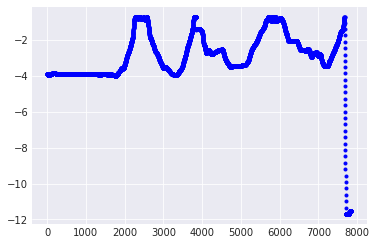

In [8]:
figure(0)
X = range(len(sonar_df['deep']))
plot(X, - sonar_df['deep'], ".b")
xlabel("")
show()

# Processing the GPS data



## Loading the data
The GPS data is also stored as a comma-separated value file called `guden_a_WITH_time_stamp.csv`. This file contains all the point taken during the fieldwork.
For the MarkVej site, the relevant points in the file which are named as`1` to `116` and `xs_pole1`, `xs_pole2`. As before the first step is to load the data into a data frame with pandas.

In [9]:
rtk_raw_df = pandas.read_csv(GPS_RTK_DATASET)
print(rtk_raw_df.head())

       Pt name        North        East  Elevation  HA  VA  SD      Time  \
0  wl_bathymry  6241422.827  540768.107     13.571 NaN NaN NaN  11:46:29   
1  wl_bathymrz  6241423.474  540767.285     13.546 NaN NaN NaN  11:46:52   
2  wl_bathymsa  6241423.504  540767.416     13.574 NaN NaN NaN  11:47:20   
3  wl_bathymsb  6241423.433  540767.385     13.548 NaN NaN NaN  11:47:31   
4  wl_bathymsc  6241424.967  540761.616     13.613 NaN NaN NaN  11:49:39   

         Date Code  
0  2020-02-13    1  
1  2020-02-13    1  
2  2020-02-13    2  
3  2020-02-13    2  
4  2020-02-13    3  


## Extract the relevant features

To simplify the process of the data, a new data frame is created named `rtk_df`, here we store only the relevant columns or attributes. Moreover, the column `Pt name` is renamed in `Pt_name` to facilitate the manipulation of the data.

In [10]:
rtk_df = pandas.DataFrame()
rtk_df['Pt_name'] = rtk_raw_df['Pt name']
rtk_df["North"] = rtk_raw_df["North"]
rtk_df["East"] = rtk_raw_df["East"]
rtk_df["Time"]  = rtk_raw_df["Time"]
rtk_df["Date"] = rtk_raw_df["Date"]
print(rtk_df.head())

       Pt_name        North        East      Time        Date
0  wl_bathymry  6241422.827  540768.107  11:46:29  2020-02-13
1  wl_bathymrz  6241423.474  540767.285  11:46:52  2020-02-13
2  wl_bathymsa  6241423.504  540767.416  11:47:20  2020-02-13
3  wl_bathymsb  6241423.433  540767.385  11:47:31  2020-02-13
4  wl_bathymsc  6241424.967  540761.616  11:49:39  2020-02-13


# Extract the poles point coordinates

The section in which the bathymetry is measured is delimited by the points `x_pole1` and `x_pole2`. In order to process the data and display it, we create two different variables holding all the relevant data for the two coordinates.


In [11]:
# Creating a new dataframe is necessary to avoid future warning in processing the data
xs2_pole1 = pandas.DataFrame(rtk_df[rtk_df['Pt_name'] == "xs2_pole1"])
xs2_pole2 = pandas.DataFrame(rtk_df[rtk_df['Pt_name'] == "xs2_pole2"])

## Extract the MarkVej RTK points

After loading the data, we need to exclude all the row with points that are not relevant for the site *MarkVej*.
To do so, we search with a regular expression all the rows that contain a number in the column `Pt_name.`

In [12]:
series_of_points = rtk_df.Pt_name.str.match(r'[0-9]{1}')
print(series_of_points.head())

0    False
1    False
2    False
3    False
4    False
Name: Pt_name, dtype: bool


This gives us a **boolean** vector representing which row has a name that is a number. After that, we take the vector and pass it to the data frame in order to get a subset of the data frame containing only the row with the `Pt_name` equal to a number.

In [13]:
narrowed_rtk_df = rtk_df[series_of_points]
print(narrowed_rtk_df.head())

   Pt_name        North        East      Time        Date
50    5680  6246961.856  539184.105  16:41:12  2020-02-13
51    5681  6246961.868  539184.088  16:41:13  2020-02-13
52    5682  6246961.901  539184.069  16:41:14  2020-02-13
53    5683  6246961.880  539184.056  16:41:15  2020-02-13
54    5684  6246961.879  539184.044  16:41:16  2020-02-13


By printing the `narrowed_rtk_df` we can see that there are some points that have an integer as a name, but they are not relevant for the **MarkVej** site. To remove them, we ask panda to create a NumPy array from the `Pt_name` value and convert the value from `string` to `int`. After retrieving the `Pt_name` values as **np.array** it is easy to compare and get only the values that are less than the value 116.

In [14]:
points = narrowed_rtk_df.Pt_name.to_numpy().astype(int)
markvej_rtk_df = pandas.DataFrame(narrowed_rtk_df[points <= 116])
print(markvej_rtk_df.head())

   Pt_name        North        East      Time        Date
58       1  6246972.482  539175.127  16:43:03  2020-02-13
59       2  6246972.477  539175.123  16:43:04  2020-02-13
60       3  6246972.477  539175.121  16:43:05  2020-02-13
61       4  6246972.456  539175.114  16:43:06  2020-02-13
62       5  6246972.428  539175.083  16:43:07  2020-02-13


## Plotting the bathymetry section
Now with the point in place, it is possible to print the bathymetry section by tracing a line between `x_pole1`  and `x_pole2`.
To do so, we can use the `utm` package combined with the `simplekml` package and output the results in google earth.
Since `simplekml` uses as input `utm` coordinates, we need to transform all our coordinates in `utm`. Since the `utm` package returns a tuple with latitude and longitude, to efficiently process the data, we create a _numpy matrix_ to split `Lat`, and `Long` attributes to the `markvej_rtk_df`

In [15]:
xs2_pole1_latlong = utm.to_latlon(float(xs2_pole1['East']),
                                   float(xs2_pole1['North']), 32, 'U')

xs2_pole2_latlong = utm.to_latlon(float(xs2_pole2['East']),
                                   float(xs2_pole2['North']), 32, 'U')

xs2_pole1['Lat'] = xs2_pole1_latlong[0]
xs2_pole1['Long'] = xs2_pole1_latlong[1]

xs2_pole2['Lat'] = xs2_pole2_latlong[0]
xs2_pole2['Long'] = xs2_pole2_latlong[1]

latlong = np.matrix([utm.to_latlon(float(markvej_rtk_df['East'].values[x]),
                                   float(markvej_rtk_df['North'].values[x]), 32, 'U')
                     for x in range(len(markvej_rtk_df))])

markvej_rtk_df['Lat'] = latlong[:, 0]
markvej_rtk_df['Long'] = latlong[:, 1]
print(markvej_rtk_df.head())

   Pt_name        North        East      Time        Date        Lat      Long
58       1  6246972.482  539175.127  16:43:03  2020-02-13  56.365788  9.634138
59       2  6246972.477  539175.123  16:43:04  2020-02-13  56.365788  9.634138
60       3  6246972.477  539175.121  16:43:05  2020-02-13  56.365788  9.634138
61       4  6246972.456  539175.114  16:43:06  2020-02-13  56.365787  9.634138
62       5  6246972.428  539175.083  16:43:07  2020-02-13  56.365787  9.634137


After extracting the latitude and longitude, we proceed to print all of them in a **kml** file which can be import in google earth. <br>
Firs lets ensure that the folder for storing the **kml** file exists.


In [16]:
from pathlib import Path
Path("./kml").mkdir(parents=True, exist_ok=True)

Then create the **kml** file

In [17]:
kml = simplekml.Kml()
style = simplekml.Style()
style.labelstyle.scale = 0 # set the label scale to 0 in order to not show the label in the maps
style.iconstyle.icon.href = 'http://maps.google.com/mapfiles/kml/shapes/placemark_circle.png'
style.iconstyle.scale = 0.5
style.iconstyle.color = simplekml.Color.yellow

for x in range(len(markvej_rtk_df)):
    pnt = kml.newpoint(name="Pt_name " + str(x + 1))
    coord = [(markvej_rtk_df['Long'].values[x], markvej_rtk_df['Lat'].values[x])]
    pnt.coords = [(markvej_rtk_df['Long'].values[x], markvej_rtk_df['Lat'].values[x])]
    pnt.style = style

kml.save("kml/MarkVejAllRtkPoints.kml")

<img src="imgs/MarkVej_all_points.png">

After printing all the points, we can also extract the section in which we want to project the points, by tracing a line between point `x_pole1` and `x_pole2`

In [18]:
start_mark = (markvej_rtk_df['Long'].values[0], markvej_rtk_df['Lat'].values[0])
end_mark = (markvej_rtk_df['Long'].values[-1], markvej_rtk_df['Lat'].values[-1])

xs2_pole1_mark = (xs2_pole1['Long'].values[0], xs2_pole1['Lat'].values[0])
xs2_pole2_mark = (xs2_pole2['Long'].values[0], xs2_pole2['Lat'].values[0])

Here we are creating a kml file containing the `xs2_pole1` and `xs2_pole2` points and the two bathymetry sections

In [19]:
kml = simplekml.Kml()
style1 = simplekml.Style()
style1.labelstyle.color = "ffa3a097"
style1.labelstyle.scale = 2
style1.iconstyle.icon.href = 'http://maps.google.com/mapfiles/kml/pushpin/ylw-pushpin.png'

start_mark = (markvej_rtk_df['Long'].values[0], markvej_rtk_df['Lat'].values[0])
end_mark = (markvej_rtk_df['Long'].values[-1], markvej_rtk_df['Lat'].values[-1])

pnt = kml.newpoint(name='MarkVej Point 1')
pnt.coords = [start_mark]
pnt.style = style1
pnt = kml.newpoint(name='MarkVej Point 116')
pnt.coords = [end_mark]
pnt.style = style1

style2 = simplekml.Style()
style2.labelstyle.color = "ffa3a097"
style2.labelstyle.scale = 3
style2.iconstyle.icon.href = 'http://maps.google.com/mapfiles/kml/pushpin/red-pushpin.png'

pnt = kml.newpoint(name='xs2_pole1')
pnt.coords = [xs2_pole1_mark]
pnt.style = style2
pnt = kml.newpoint(name='xs2_pole2')
pnt.coords = [xs2_pole2_mark]
pnt.style = style2

ls = kml.newlinestring(name='Bathymetry section')
ls.coords = [start_mark, end_mark]
ls.extrude = 1
ls.altitudemode = simplekml.AltitudeMode.relativetoground
ls.style.linestyle.width = 1
ls.style.linestyle.color = "ffa4a83a"

ls1 = kml.newlinestring(name='Bathymetry section')
ls1.coords = [xs2_pole1_mark, xs2_pole2_mark]
ls1.extrude = 1
ls1.altitudemode = simplekml.AltitudeMode.relativetoground
ls1.style.linestyle.width = 5
ls1.style.linestyle.color = simplekml.Color.blue

kml.save("kml/MarkVejSection.kml")

<img src="imgs/MarkVej_bathimetry_section_2.png">

# Combining the dataset
## Removing the sonar point exceding the begin and end of the RTK timestamp
Since the sonar starts collecting data as soon as the application is launched and the sonar is in water, some of the measure in the sonar data frame are not relevant.
For this reason, we need to remove the measure that was taken before the timestamp of `Pt_name` 1 and after `Pt_name` 116. To facilitate this operation, we add a feature on our `markvej_rkt_df` with the Unix timestamp.

In [20]:
timestamps = [datetime.datetime.strptime(markvej_rtk_df['Date'].values[x] + " " \
                                         + markvej_rtk_df['Time'].values[x], "%Y-%m-%d %H:%M:%S").timestamp()
                                         for x in range(len(markvej_rtk_df))]
markvej_rtk_df['Timestamp'] = timestamps
markvej_rtk_df.reset_index()
print(markvej_rtk_df.head())

   Pt_name        North        East      Time        Date        Lat  \
58       1  6246972.482  539175.127  16:43:03  2020-02-13  56.365788   
59       2  6246972.477  539175.123  16:43:04  2020-02-13  56.365788   
60       3  6246972.477  539175.121  16:43:05  2020-02-13  56.365788   
61       4  6246972.456  539175.114  16:43:06  2020-02-13  56.365787   
62       5  6246972.428  539175.083  16:43:07  2020-02-13  56.365787   

        Long     Timestamp  
58  9.634138  1.581609e+09  
59  9.634138  1.581609e+09  
60  9.634138  1.581609e+09  
61  9.634138  1.581609e+09  
62  9.634137  1.581609e+09  


### Creating the timestamp filter
After adding the *Timestamp* attribute to the `markvej_rkt_df`, we can create the filter to apply to the `sonar_df`. To comapre the value, we need to multiply the *Timestamp* of the rtk by `1e3` since the `sonar_df` uses a non standar timestamp value

In [21]:
timestamp_filter = ((sonar_df['timestamp'] < markvej_rtk_df['Timestamp'].values[115] * 1e3) & \
                    (sonar_df['timestamp'] > markvej_rtk_df['Timestamp'].values[0] * 1e3))

After that, we can apply the filter and create a new data frame `sonar_rtk_df` in order to facilitate the data analysis.

In [22]:
sonar_rtk_df = pandas.DataFrame(sonar_df[timestamp_filter])
sonar_rtk_df.reset_index()
print(sonar_rtk_df.head())

       deep        date             time      timestamp
2520  0.848  2020-02-13  16:43:03.128000  1581608583128
2521  0.848  2020-02-13  16:43:03.130000  1581608583130
2522  0.848  2020-02-13  16:43:03.281000  1581608583281
2523  0.848  2020-02-13  16:43:03.282000  1581608583282
2524  0.848  2020-02-13  16:43:03.286000  1581608583286


## Distance
Now we can calculate the distance between the two points in meters and divide it into buckets of 10[cm] in order to plot the bathymetry profile.

The first idea was to use the Euclidian distance using the **utm** coordinates of the two points.

In [23]:
euclidean_dist_point_1_116 = np.sqrt((markvej_rtk_df['North'].values[0] - markvej_rtk_df['North'].values[-1])**2 + \
                         (markvej_rtk_df['East'].values[0] - markvej_rtk_df['East'].values[-1])**2)
print(euclidean_dist_point_1_116)

24.150034741840727


This distance seems reasonable, but the Euclidean distance does not take into consideration the curvature of the earth.
To correct this error, we calculate the distance with the `gepy` package. This package expects two-point in *latitude* and *longitude* coordinates, so the first step was to convert the points 1 and 116 in latitude and longitude coordinates. And then calculate the distance in `m` with `geopy.distance.distance` and assign it to the `river_cross_section_m` variable

In [24]:
coord_1 = (markvej_rtk_df['Lat'].values[0], markvej_rtk_df['Long'].values[0])
coord_116 = (markvej_rtk_df['Lat'].values[-1], markvej_rtk_df['Long'].values[-1])
distance_points_1_116 = geopy.distance.distance(coord_1, coord_116).m

distance_xs2_pole1_pole2 = geopy.distance.distance((xs2_pole1['Lat'].values[0], xs2_pole1['Long'].values[0]),
                                                 (xs2_pole2['Lat'].values[0], xs2_pole2['Long'].values[0])).m
print(distance_xs2_pole1_pole2)

36.477364853542845


## Projecting the points

To easilly compare the timestamp between the RTK and the sonar, we add a `unixtimestamp` attribute to the sonar data frame.

In [25]:
sonar_rtk_df['unix_timestamp'] = [int(round(x / 1e3)) for x in sonar_rtk_df['timestamp'].values]

Since we have more bathymetry measure than RTK points, for each RTK point, there will be multiple measures for each point. In order to exclude the outliers, we will take the **median** of all the measurements for each track point. We need to convert all the missing point into an array containing only one value equal to `nan` to prevent a Numpy warning.

In [26]:
all_measure_per_points = [sonar_rtk_df[sonar_rtk_df['unix_timestamp'] == markvej_rtk_df['Timestamp'].values[x]].deep.values
                          for x in range(len(markvej_rtk_df))]
all_measure_per_points_clean = np.array([[np.nan] if x.size == 0 \
                                         else x for x in all_measure_per_points]) # convert all the empty array in an array conataining ['nan']
median_iter = map(lambda x: np.median(x), all_measure_per_points_clean)
markvej_rtk_df['Bathymetry'] = np.fromiter(median_iter, dtype=np.float)

In [27]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=5, metric="euclidean")
x = sonar_rtk_df['unix_timestamp'].values.reshape(-1, 1)
model.fit(x, list(range(len(sonar_rtk_df["unix_timestamp"].values))))
predicted = model.predict(markvej_rtk_df['Timestamp'].values.reshape(-1, 1))
bathymetry_knn = []
for item in predicted:
    bathymetry_knn.append(sonar_rtk_df['deep'].values[item])
markvej_rtk_df['Bathymetry_knn'] = bathymetry_knn


### Approximate Plotting

Now that we have the median for each point we can ploat an approximation where $x$ is the point number and $y$ is the 

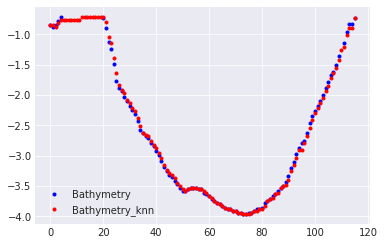

In [28]:
fig, ax = subplots()
X = range(len(markvej_rtk_df))
plot(X, - markvej_rtk_df['Bathymetry'].values, '.b', label="Bathymetry")
plot(X, - markvej_rtk_df['Bathymetry_knn'].values, '.r', label='Bathymetry_knn')
ax.legend()
xlabel("")
show()
fig.savefig('plot/markvejapprox.svg', format='svg')

### Precise Plotting

Now we can calculate the precise distance between each point and plot from left to right. <br>
Since the left of the river is considered by having the back to the source of the river. <br>
<img src="imgs/Coordinates.svg">
In order to process the data, we can calculate the distance between each point and store it in a new attribute on the `markvej_rtk_df`.

In [29]:
markvej_rtk_df['Distance'] = [geopy.distance.distance(coord_1, (markvej_rtk_df['Lat'].values[x], markvej_rtk_df['Long'].values[x])).m 
                              for x in range(len(markvej_rtk_df))]
print(markvej_rtk_df.head())

   Pt_name        North        East      Time        Date        Lat  \
58       1  6246972.482  539175.127  16:43:03  2020-02-13  56.365788   
59       2  6246972.477  539175.123  16:43:04  2020-02-13  56.365788   
60       3  6246972.477  539175.121  16:43:05  2020-02-13  56.365788   
61       4  6246972.456  539175.114  16:43:06  2020-02-13  56.365787   
62       5  6246972.428  539175.083  16:43:07  2020-02-13  56.365787   

        Long     Timestamp  Bathymetry  Bathymetry_knn  Distance  
58  9.634138  1.581609e+09       0.848           0.848  0.000000  
59  9.634138  1.581609e+09       0.876           0.848  0.006406  
60  9.634138  1.581609e+09       0.848           0.876  0.007813  
61  9.634138  1.581609e+09       0.780           0.821  0.029080  
62  9.634137  1.581609e+09       0.711           0.766  0.069683  


### Distance Plotting

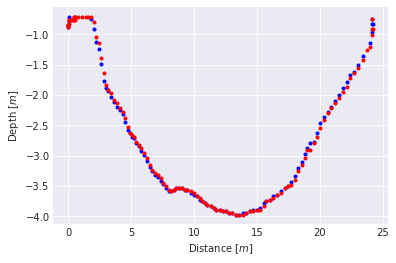

In [30]:
figure(1)
X = range(len(markvej_rtk_df))
plot(markvej_rtk_df['Distance'], - markvej_rtk_df['Bathymetry'].values, '.b')
plot(markvej_rtk_df['Distance'], - markvej_rtk_df['Bathymetry_knn'].values, '.r')
xlabel("Distance [$m$]")
ylabel("Depth [$m$]")
show()

# Sectioning

After retrieving the distance of the two poles, we proceed by sectioning the line in segments of 10 cm longs.
In order to do so, we use the fundamental equation of the line
\begin{equation}
\Delta_y = m \Delta_x
\end{equation}
Where we define $m$ as our increment or delta ($\Delta$). In this case, $m$ can be express as the ratio between, $\Delta_y$, and $\Delta_x$.
$$
\Delta_y = y_f - y_i \quad,\quad \Delta_x = x_f - x_i
$$
As described in the previous image, *North* is the $y$ axis and *East* is the $x$ axis.
With this informations, we can proceed to calculate $\Delta_y$ and $\Delta_x$, as shown below.

In [31]:
dy = float(xs2_pole2['North'].values[0]) - float(xs2_pole1['North'].values[0])
dx = float(xs2_pole2['East'].values[0]) - float(xs2_pole1['East'].values[0])
m = np.float(dy)/np.float(dx)

Now that we know the value of $m$, we can proceed and calculate the increment in $x$ and in $y$ for the next point. In order to not confuse the two different increment we will call theese two increments $\Delta_{x1}$ and $\Delta_{y1}$. From the formula for the distance between two points we know that
\begin{equation}
dx^2 = \Delta_{x1}^2 + \Delta_{y1}^2
\end{equation}

Where in this case $dx = 0.1 [m]$.
And from the euqtion of the line:
$$
\Delta_{y1} = m \Delta_{x1}
$$
And if we plug this in the equation of the distance between two points we find that:

\begin{align}
dx^2 & = (m \Delta_{x1})^2 + \Delta_{x1}^2 \\
dx^2 & = \Delta_{x1}^2 (m^2 + 1)
\end{align}
And finally:
$$
\Delta_{x1} = \sqrt{\frac{dx^2}{m^2 + 1}} \quad \quad \Delta_{y1} = \sqrt{dx^2 - \Delta_{x1}^2}
$$

In [32]:
dx1 = np.sqrt(np.power(np.float(0.1), 2)/((m)**2 + 1.0))
print(dx1)
dy1 = np.sqrt(np.power(np.float(0.1), 2) - dx1**2)
print(dy1)

0.0655121585601306
0.07555234662664231


After finding the increments, we can find all the coordinates of the points by adding the increment to the *North* and *East* coordinate starting from **xs2_pole1**.

In [33]:
sections_enu_coord = []

for i in range(int(distance_xs2_pole1_pole2 / 0.1)):
    sections_enu_coord.append((xs2_pole1['East'].values[0] + dx1 * i, xs2_pole1['North'].values[0] - dy1 * i))
sections_enu_coord = np.asarray(sections_enu_coord)

sections_utm_coord = np.asarray(list(map(lambda x: utm.to_latlon(x[0], x[1], 32, 'U'), sections_enu_coord)))

Now we can create a *KML* file called *division.kml* and confirm that the first and last point are aligned with **xs2_pole1**, and **xs2_pole2**. 

In [34]:
kml = simplekml.Kml()
style1.labelstyle.scale = 0 # set the label scale to 0 in order to not show the label in the maps
style1.iconstyle.icon.href = 'http://maps.google.com/mapfiles/kml/shapes/placemark_circle.png'
style1.iconstyle.scale = 0.5
style1.iconstyle.color = simplekml.Color.yellow

for x in range(len(sections_utm_coord)):
    pnt = kml.newpoint(name='Point' + str(x))
    pnt.coords = [np.flipud(sections_utm_coord[x])]
    pnt.style = style1

style2 = simplekml.Style()
style2.labelstyle.color = "ffa3a097"
style2.labelstyle.scale = 3
style2.iconstyle.icon.href = 'http://maps.google.com/mapfiles/kml/pushpin/red-pushpin.png'

pnt = kml.newpoint(name='xs2_pole1')
pnt.coords = [xs2_pole1_mark]
pnt.style = style2
pnt = kml.newpoint(name='xs2_pole2')
pnt.coords = [xs2_pole2_mark]
pnt.style = style2

kml.save("kml/divisions.kml")

<img src="imgs/Sections.png">

# Classification of the points


In [41]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=3)
rtk_points = np.squeeze(np.dstack((markvej_rtk_df['East'].values, markvej_rtk_df['North'].values)))
bathymetry = np.full(len(sections_enu_coord), np.nan) 
bathymetry_knn = np.full(len(sections_enu_coord), np.nan) 
model.fit(sections_enu_coord, list(range(len(sections_enu_coord))))
predicted = model.predict(rtk_points)
for index in range(len(predicted)):
    bathymetry[predicted[index]] = markvej_rtk_df['Bathymetry'].values[index]
    bathymetry_knn[predicted[index]] = markvej_rtk_df['Bathymetry_knn'].values[index]

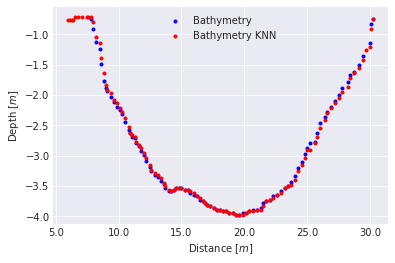

In [42]:
fig, ax = subplots()
X = range(len(sections_enu_coord))
plot(X, - np.asarray(bathymetry), '.b', label = "Bathymetry")
plot(X, - np.asarray(bathymetry_knn), '.r', label = "Bathymetry KNN")
labels=np.asarray(ax.get_xticks().tolist(), dtype=np.float) * 0.1
ax.set_xticklabels(labels)
ax.legend()
xlabel("Distance [$m$]")
ylabel("Depth [$m$]")
show()
fig.savefig('plot/markvej_projection.svg', format='svg')

# Exporting the results

In [53]:
from pathlib import Path
Path("./csv_results").mkdir(parents=True, exist_ok=True)

In [55]:
results = pandas.DataFrame()
results['Distance_in_m'] = [round(x * 0.1, 3) for x in range(len(bathymetry))]
results['Bathymetry'] = bathymetry
results['Bathymetry_KNN'] = bathymetry_knn
results['North'] = sections_enu_coord[:,1]
results['East'] = sections_enu_coord[:,0]
results['Lat'] = sections_utm_coord[:,0]
results['Long'] = sections_utm_coord[:,1]
results.to_csv("csv_results/Markvej_cross_section.csv",index=False)
markvej_rtk_df.to_csv("csv_results/Markve_rtk_and_bathymetry.csv", index=False)